# Evaluation of U-Net 

### Final Edit by Salma and Klara

27th Of Feb

### validation set

In [2]:
!cat ../data/4_filelists/VALIDATION.txt

MFGTMPcx7_170702000001_B23f07d0.png
MFGTMPcx7_170702000001_F11f10d0.png
MFGTMPcx7_170702090001_A08f09d0.png
MFGTMPcx7_170702090001_A20f02d0.png
MFGTMPcx7_170702090001_G03f02d0.png
MFGTMPcx7_170702090001_K22f14d0.png
MFGTMPcx7_170702090001_P01f02d0.png
MFGTMPcx7_170731090001_A01f04d0.png
MFGTMPcx7_170731090001_B05f12d0.png
MFGTMPcx7_170802000001_I10f05d0.png


### test set

In [2]:
!cat ../data/4_filelists/TEST.txt

MFGTMPcx7_170702000001_G14f03d0.png
MFGTMPcx7_170702090001_B22f15d0.png
MFGTMPcx7_170702090001_C08f14d0.png
MFGTMPcx7_170702090001_H04f01d0.png
MFGTMPcx7_170702090001_P07f14d0.png
MFGTMPcx7_170731090001_B14f09d0.png
MFGTMPcx7_170731090001_D11f13d0.png
MFGTMPcx7_170731090001_I12f05d0.png
MFGTMPcx7_170801050001_G02f01d0.png
MFGTMPcx7_170803210001_J12f29d0.png


### Libraries

In [3]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

import skimage.io
import skimage.morphology
import skimage.segmentation

from config import config_vars
import utils

import  utils.metrics
#! pip install pandas==0.23.4

/proj/berzelius-2021-21/users/Salma-files/envs/UNET_TF_1/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


### Evalution metrics and functions

In [4]:
import numpy as np
import pandas as pd


def intersection_over_union(ground_truth, prediction):
    
    # Count objects
    true_objects = len(np.unique(ground_truth))
    pred_objects = len(np.unique(prediction))  
    
    # Compute intersection
    h = np.histogram2d(ground_truth.flatten(), prediction.flatten(), bins=(true_objects,pred_objects))
    intersection = h[0]
    
    # Area of objects
    area_true = np.histogram(ground_truth, bins=true_objects)[0]
    area_pred = np.histogram(prediction, bins=pred_objects)[0]
    
    # Calculate union
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)
    union = area_true + area_pred - intersection
    
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    
    # Compute Intersection over Union
    union[union == 0] = 1e-9
    IOU = intersection/union
    
    return IOU
    


def measures_at(threshold, IOU):
    
    matches = IOU > threshold
    
    true_positives = np.sum(matches, axis=1) == 1   # Correct objects
   
    false_negatives = np.sum(matches, axis=1) == 0  # Missed objects
    
    
    FP_matches = IOU > 0.5
    false_positives = np.sum(FP_matches, axis=0) == 0  # Extra objects
    
    assert np.all(np.less_equal(true_positives, 1))
    assert np.all(np.less_equal(false_positives, 1))
    assert np.all(np.less_equal(false_negatives, 1))
    
    TP, FP, FN = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
    
    f1 = 2*TP / (2*TP + FP + FN + 1e-9)
    
    return f1, TP, FP, FN

# Compute Average Precision for all IoU thresholds

def compute_af1_results(ground_truth, prediction, results, image_name):
   
    # Compute IoU
    IOU = intersection_over_union(ground_truth, prediction)
    if IOU.shape[0] > 0:
        jaccard = np.max(IOU, axis=0).mean()
    else:
        jaccard = 0.0
    
    # Calculate F1 score at all thresholds
    for t in np.arange(0.5, 1.0, 0.05):
        f1, tp, fp, fn = measures_at(t, IOU)
        res = {"Image": image_name, "Threshold": t, "F1": f1, "Jaccard": jaccard, "TP": tp, "FP": fp, "FN": fn}
        row = len(results)
        results.loc[row] = res
        
    return results

# Count number of False Negatives at 0.9 IoU

def get_false_negatives(ground_truth, prediction, results, image_name, threshold=0.9):
    
    # Compute IoU
    IOU = intersection_over_union(ground_truth, prediction)
    
    true_objects = len(np.unique(ground_truth))
    if true_objects <= 1:
        return results
        
    area_true = np.histogram(ground_truth, bins=true_objects)[0][1:]
    true_objects -= 1
    
    # Identify False Negatives
    matches = IOU > threshold
    false_negatives = np.sum(matches, axis=1) == 0  # Missed objects

    data = np.asarray([ 
        area_true.copy(), 
        np.array(false_negatives, dtype=np.int32)
    ])

    results = pd.concat([results, pd.DataFrame(data=data.T, columns=["Area", "False_Negative"])])
        
    return results

### WE changed the threshold of FP to 0.5
### This might change so many things
### So, the sum of TP and FP is not predicted objects since some objects are not FP and not also TP.
### FP is calculated from FN (0.9)

def get_false_positives(ground_truth, prediction, results, image_name, threshold=0.5):
    
    # Compute IoU
    IOU = intersection_over_union(ground_truth, prediction)
    
    pred_objects = len(np.unique(prediction))
    if pred_objects <= 1:
        return results
        
    area_pred = np.histogram(prediction, bins = pred_objects)[0][1:]
    pred_objects -= 1
    # Identify False Positives
    matches = IOU > threshold
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    
    data = np.asarray([ 
        area_pred.copy(), 
        np.array(false_positives, dtype=np.int32)
    ])

    results = pd.concat([results, pd.DataFrame(data=data.T, columns=["Area", "False_Positive"])])
        
    return results

### I have added this here to calculate the area of all gold objects

def get_gold_objects(ground_truth, prediction, results, image_name):
    
    
    true_objects = len(np.unique(ground_truth))
    if true_objects <= 1:
        return results
    
    area_true = np.histogram(ground_truth, bins=true_objects)[0][1:]
    
    true_objects -= 1
    
    
    data = np.asarray([ 
        np.arange(true_objects),
        area_true.copy()])
   
    results = pd.concat([results, pd.DataFrame(data=data.T, columns=["Gold_Object", "Area"])])
        
    return results


## This is for calculating the area of all predicted objects
def get_predicted_objects(ground_truth, prediction, results, image_name):
    
    
    pred_objects = len(np.unique(prediction))
    if pred_objects <= 1:
        return results
    
    area_pred = np.histogram(prediction, bins=pred_objects)[0][1:]
    
    pred_objects -= 1
    
    
    data = np.asarray([ 
        np.arange(pred_objects),
        area_pred.copy()])
   
    results = pd.concat([results, pd.DataFrame(data=data.T, columns=["Pred_Object", "Area"])])
        
    return results

# Count the number of splits and merges
def get_splits_and_merges(ground_truth, prediction, results, image_name):

    # Compute IoU
    IOU = intersection_over_union(ground_truth, prediction)
    
    matches = IOU > 0.1
    merges = np.sum(matches, axis=0) > 1
    splits = np.sum(matches, axis=1) > 1
    r = {"Image_Name":image_name, "Merges":np.sum(merges), "Splits":np.sum(splits)}
    results.loc[len(results)+1] = r
    return results

### Auxiliary visualization function

In [5]:
# Display prediction along with segmentation to visualize errors

def show(ground_truth, prediction, threshold=0.9, image_name="N"):
    
    # Compute Intersection over Union
    IOU = intersection_over_union(ground_truth, prediction)
    
    # Create diff map
    diff = np.zeros(ground_truth.shape + (3,))
    A = ground_truth.copy()
    B = prediction.copy()
    A[A > 0] = 1
    B[B > 0] = 1
    D = A - B
    #diff[D > 0,:2] = 1
    #diff[D < 0,1:] = 1
    
    # Object-level errors
    C = IOU.copy()
    C[C>=threshold] = 1
    C[C<threshold] = 0
    extra = np.where(np.sum(C,axis=0) == 0)[0]
    
    
    ### We changed the threshold of FP to 0.5 even here in show function
    FP_threshold = 0.5
    P = IOU.copy()
    P[P>=FP_threshold] = 1
    P[P<FP_threshold] = 0
    missed = np.where(np.sum(P,axis=1) == 0)[0]
    
    print()
    print('missed: '+str(missed))
    print()
    print('extra: '+str(extra))

    for m in missed:
        diff[ground_truth == m+1, 0] = 1
    for e in extra:
        diff[prediction == e+1, 2] = 1
    
    # Display figures
    fig, ax = plt.subplots(1, 3, figsize=(25,10))
    ax[0].imshow(ground_truth)
    ax[0].set_title("True objects:"+str(len(np.unique(ground_truth))-1))# correction corr script: -1
    ax[1].imshow(diff)
    ax[1].set_title("Segmentation errors (missed):"+str(len(missed)))
    ax[2].imshow(prediction)
    ax[2].set_title("Predicted objects:"+str(len(np.unique(prediction))-1))# correction corr script: -1
    #ax[3].imshow(IOU)
    #ax[3].set_title(image_name)

# Run the evaluation

## This part is for evaluating UNet models  3, 12, and 14.

In [6]:
import utils.dirtools

# Partition of the data to make predictions (test or validation)
config_vars['path_files_training'] = '../data/4_filelists/training.txt'
config_vars['path_files_validation'] ='../data/4_filelists/VALIDATION.txt'
config_vars['path_files_test'] = '../data/4_filelists/TEST.txt'

partition = "validation"

experiment_name = 'Model_3_Malou'

config_vars = utils.dirtools.setup_experiment(config_vars, experiment_name)

data_partitions = utils.dirtools.read_data_partitions(config_vars)

config_vars




{'home_folder': '/proj/berzelius-2021-21/users/klara/Segmentation/data/',
 'model_file': '/proj/berzelius-2021-21/users/klara/Segmentation/data/experiments/Model_3_Malou/model.hdf5',
 'input_dimensions': 1,
 'root_directory': '/proj/berzelius-2021-21/users/klara/Segmentation/data/',
 'learning_rate': 0.0001,
 'epochs': 15,
 'cell_min_size': 10,
 'max_training_images': 130,
 'steps_per_epoch': 500,
 'pixel_depth': 8,
 'batch_size': 1,
 'val_batch_size': 1,
 'rescale_labels': True,
 'crop_size': 256,
 'boundary_boost_factor': 1,
 'object_dilation': 3,
 'raw_annotations_dir': '/proj/berzelius-2021-21/users/klara/Segmentation/data/1_raw_annotations/',
 'normalized_images_dir': '/proj/berzelius-2021-21/users/klara/Segmentation/data/norm_images/',
 'boundary_labels_dir': '/proj/berzelius-2021-21/users/klara/Segmentation/data/boundary_labels/',
 'path_files_training': '../data/4_filelists/training.txt',
 'path_files_validation': '../data/4_filelists/VALIDATION.txt',
 'path_files_test': '../da

In [7]:
import glob

all_images = data_partitions['test']
all_images

['MFGTMPcx7_170702000001_G14f03d0.png',
 'MFGTMPcx7_170702090001_B22f15d0.png',
 'MFGTMPcx7_170702090001_C08f14d0.png',
 'MFGTMPcx7_170702090001_H04f01d0.png',
 'MFGTMPcx7_170702090001_P07f14d0.png',
 'MFGTMPcx7_170731090001_B14f09d0.png',
 'MFGTMPcx7_170731090001_D11f13d0.png',
 'MFGTMPcx7_170731090001_I12f05d0.png',
 'MFGTMPcx7_170801050001_G02f01d0.png',
 'MFGTMPcx7_170803210001_J12f29d0.png']

## Run evaluation (3, 12, 14)

MFGTMPcx7_170702000001_G14f03d0.png


/proj/berzelius-2021-21/users/Salma-files/envs/UNET_TF_1/lib/python3.6/site-packages/ipykernel_launcher.py:101: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/proj/berzelius-2021-21/users/Salma-files/envs/UNET_TF_1/lib/python3.6/site-packages/ipykernel_launcher.py:130: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



MFGTMPcx7_170702090001_B22f15d0.png
MFGTMPcx7_170702090001_C08f14d0.png
MFGTMPcx7_170702090001_H04f01d0.png
MFGTMPcx7_170702090001_P07f14d0.png
MFGTMPcx7_170731090001_B14f09d0.png
MFGTMPcx7_170731090001_D11f13d0.png


/proj/berzelius-2021-21/users/Salma-files/envs/UNET_TF_1/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


MFGTMPcx7_170731090001_I12f05d0.png


/proj/berzelius-2021-21/users/Salma-files/envs/UNET_TF_1/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/proj/berzelius-2021-21/users/Salma-files/envs/UNET_TF_1/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


MFGTMPcx7_170801050001_G02f01d0.png
MFGTMPcx7_170803210001_J12f29d0.png


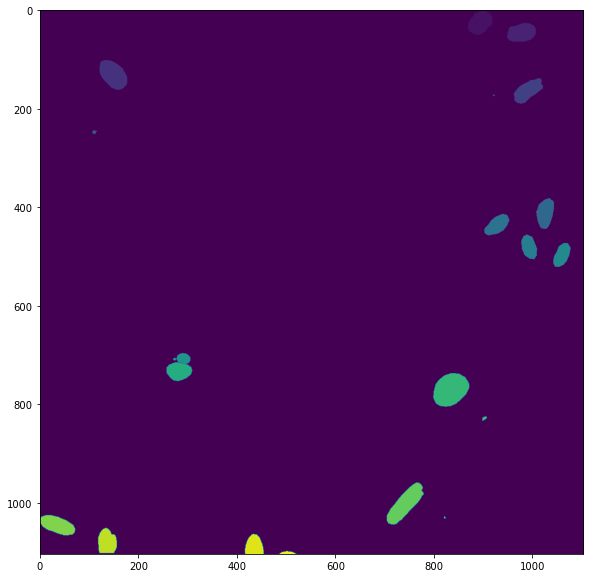

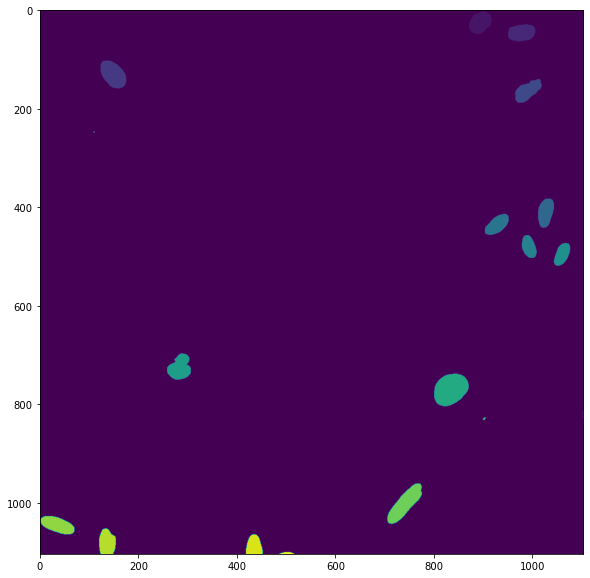

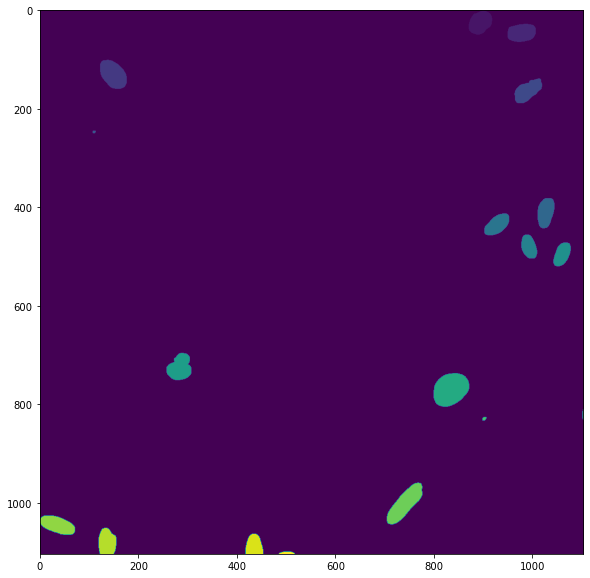

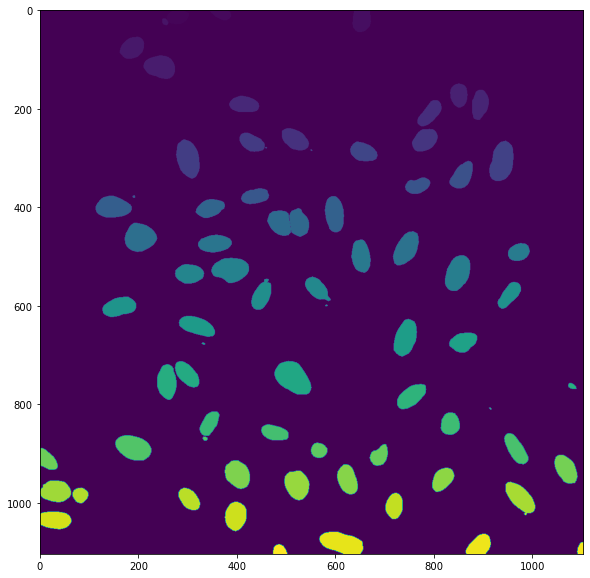

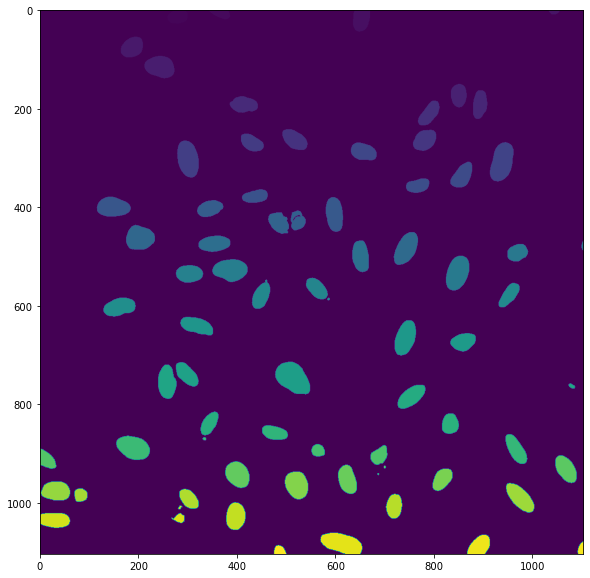

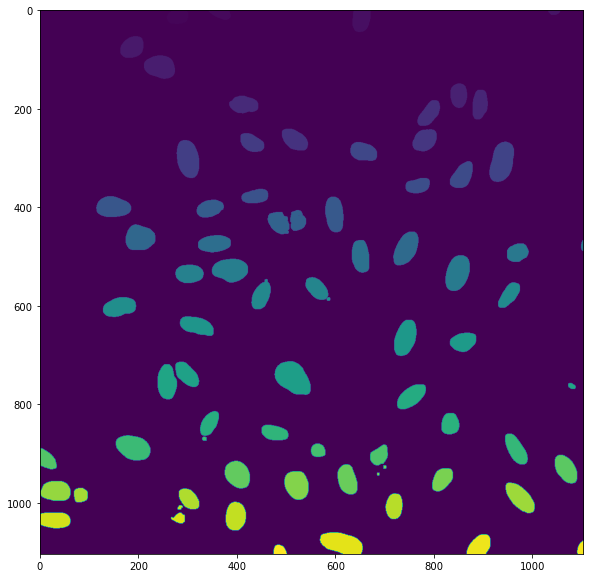

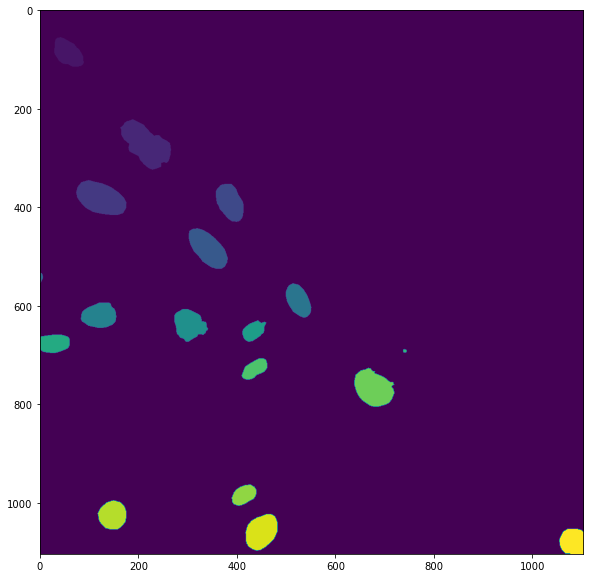

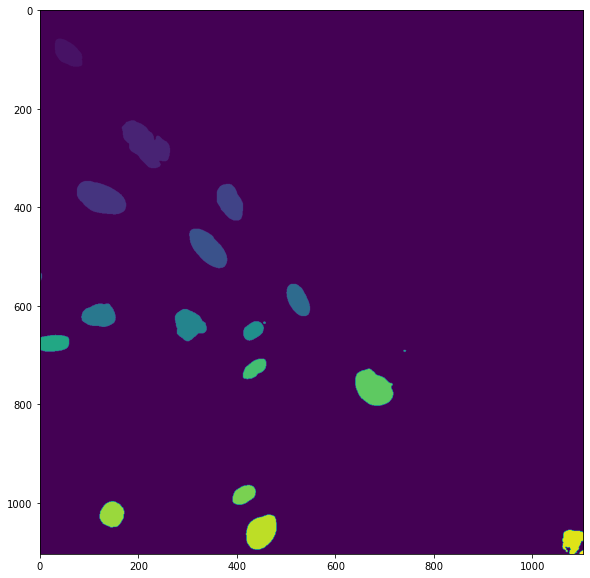

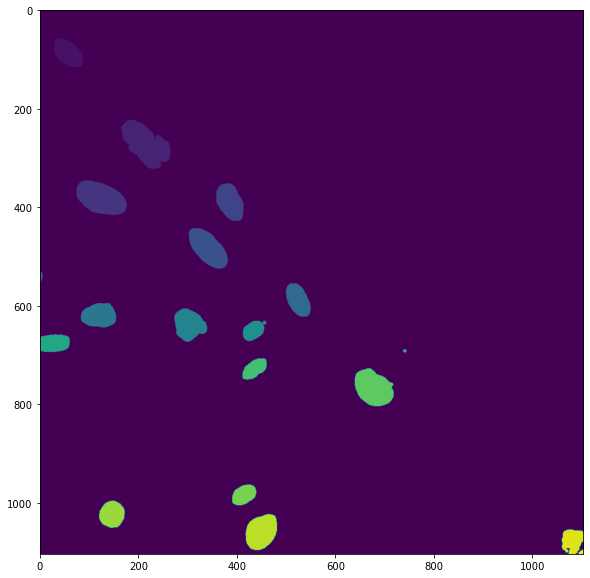

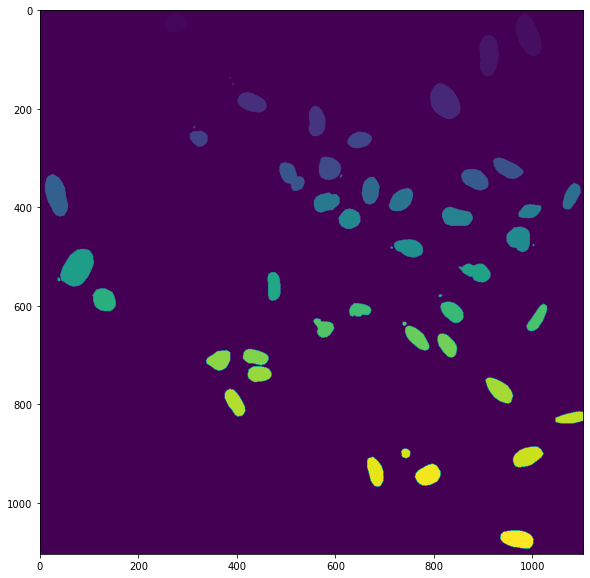

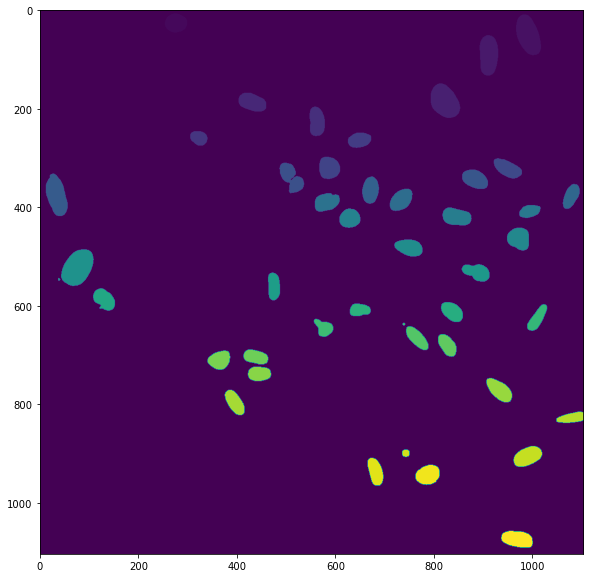

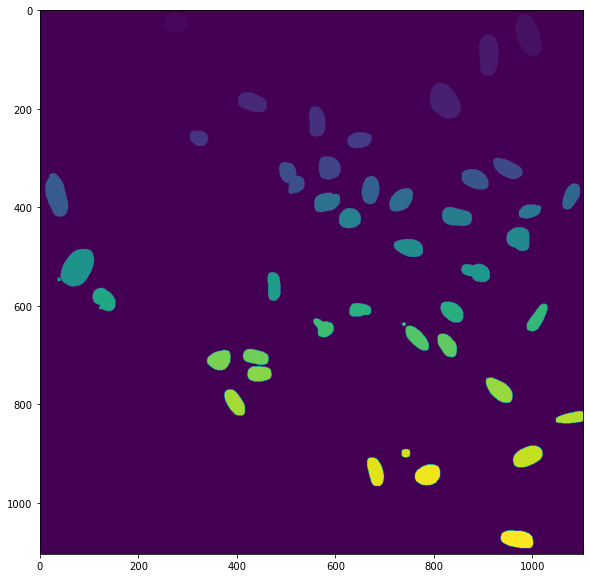

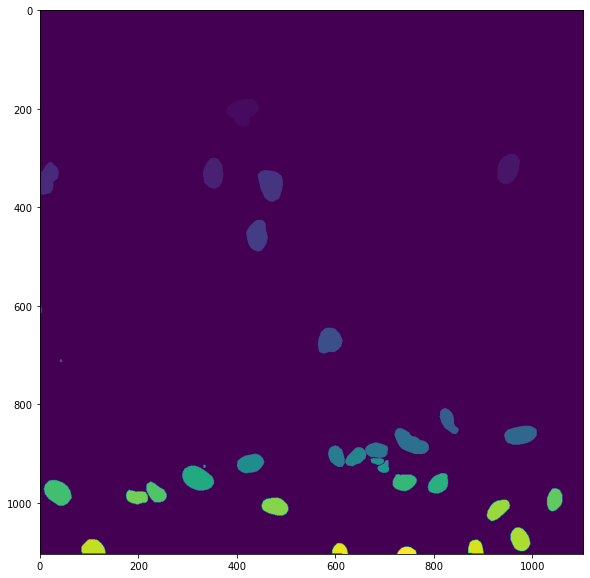

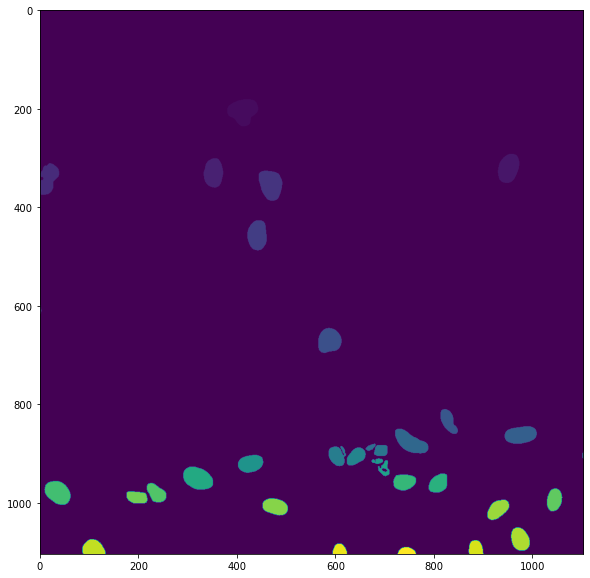

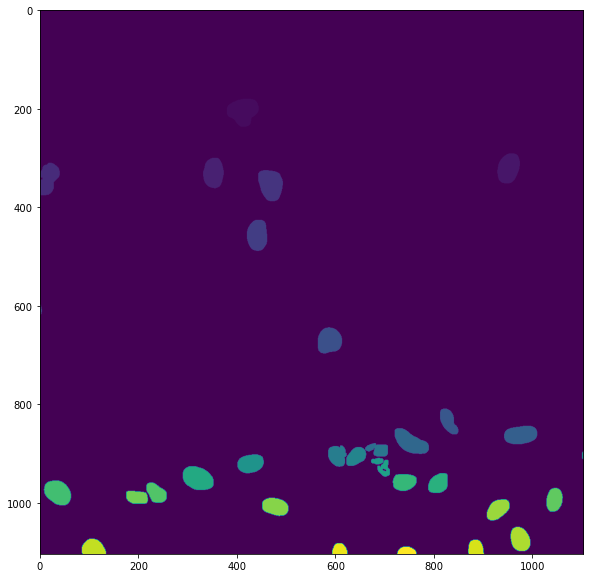

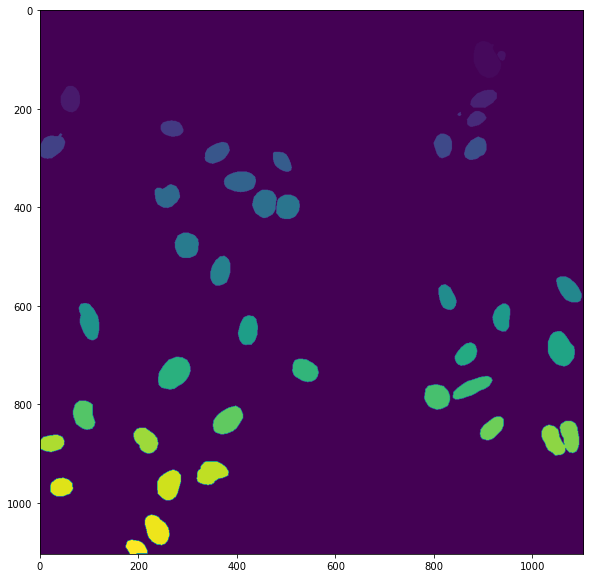

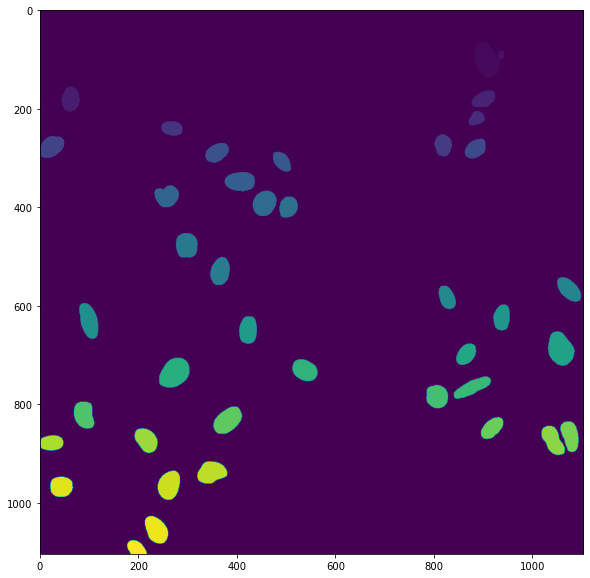

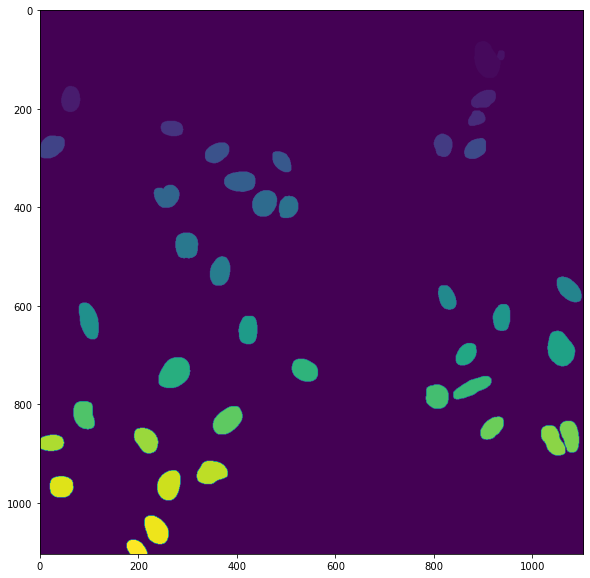

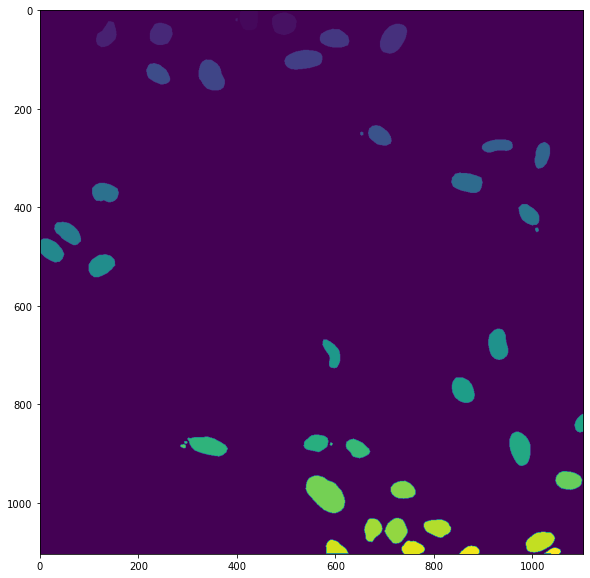

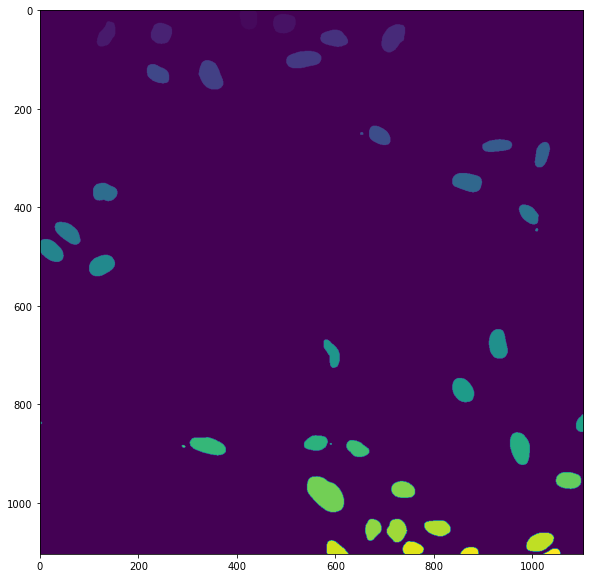

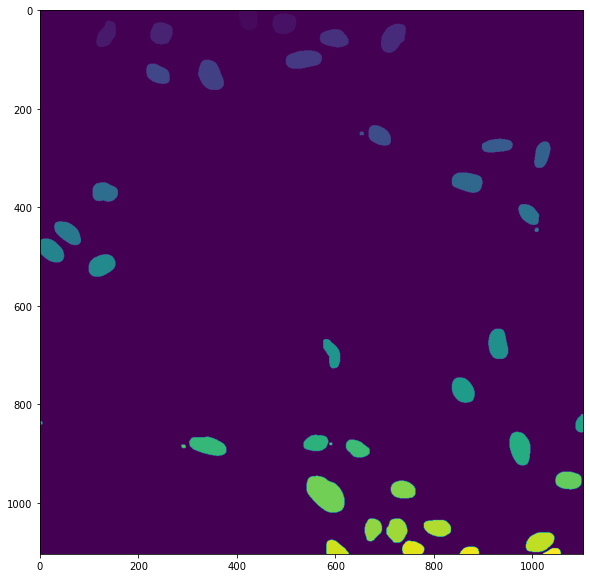

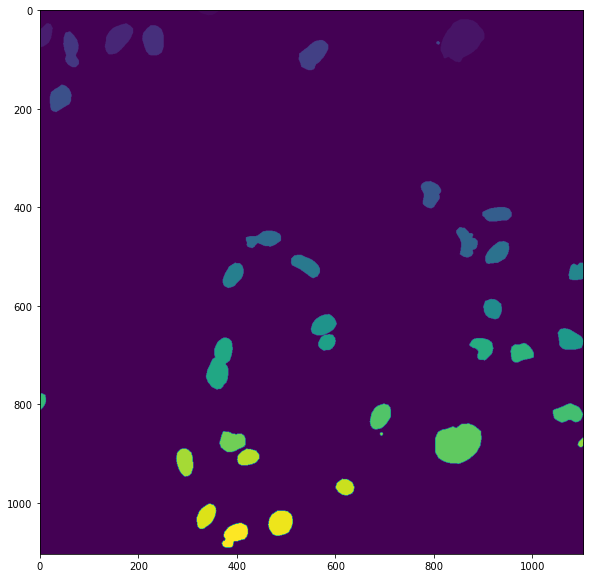

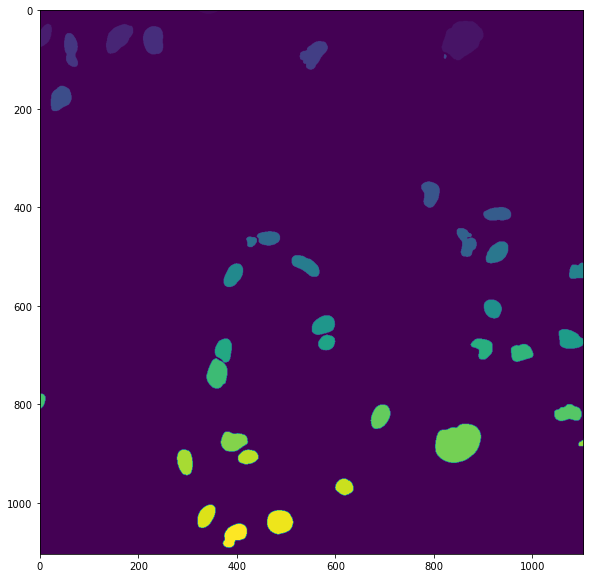

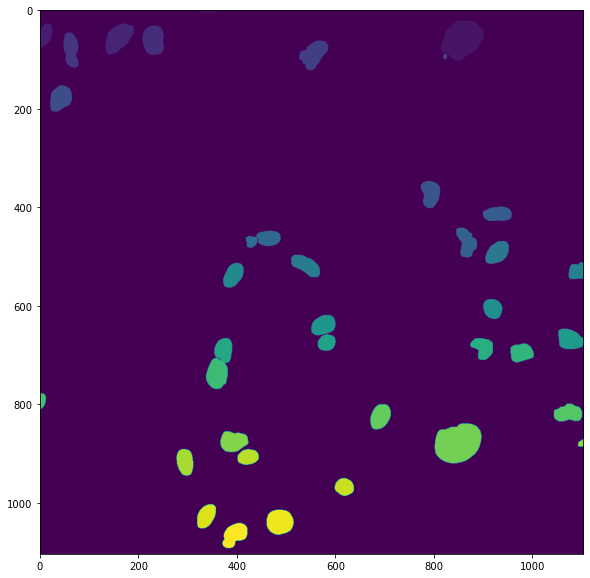

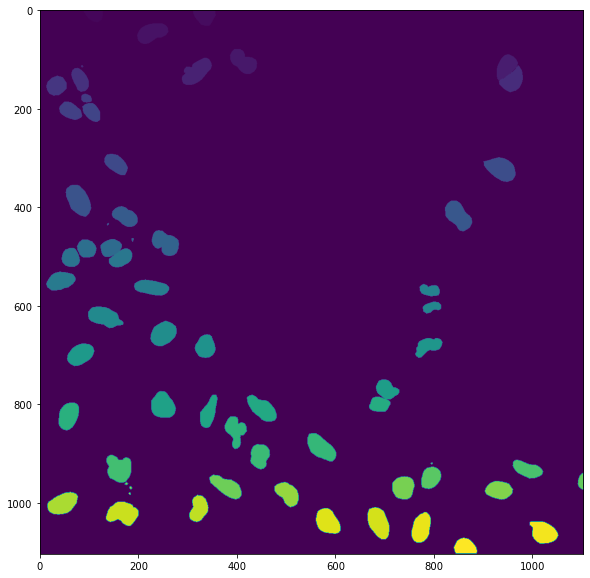

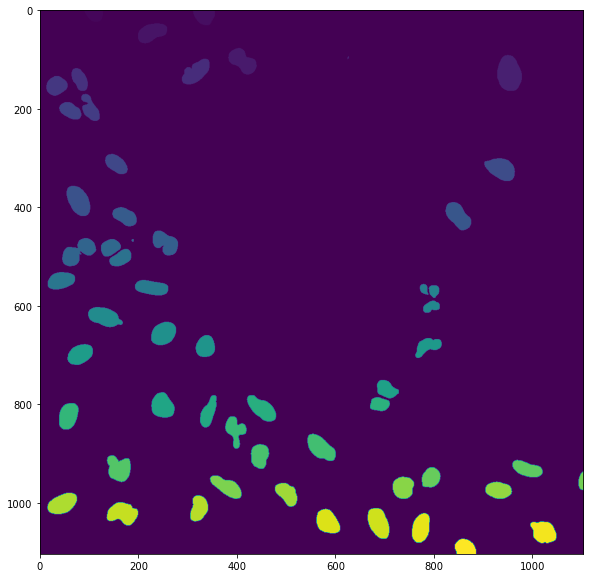

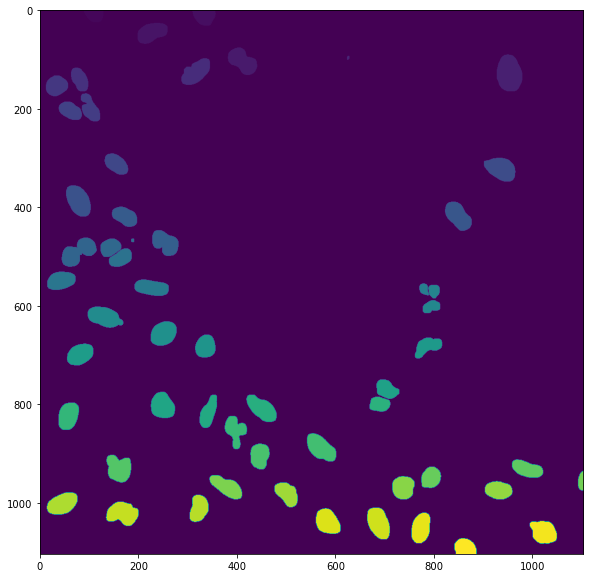

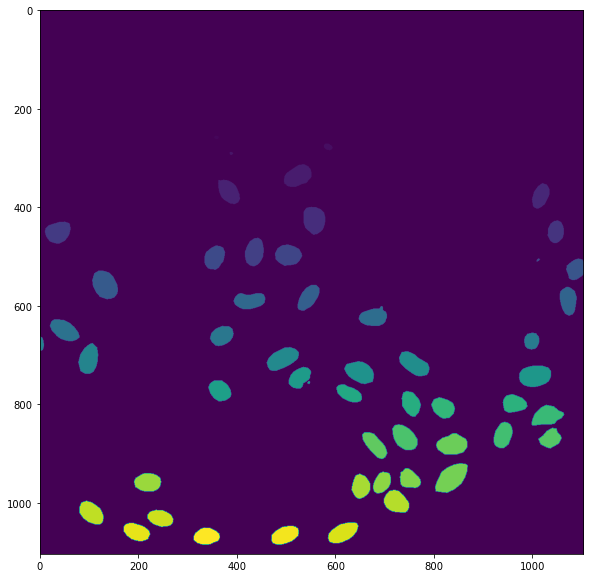

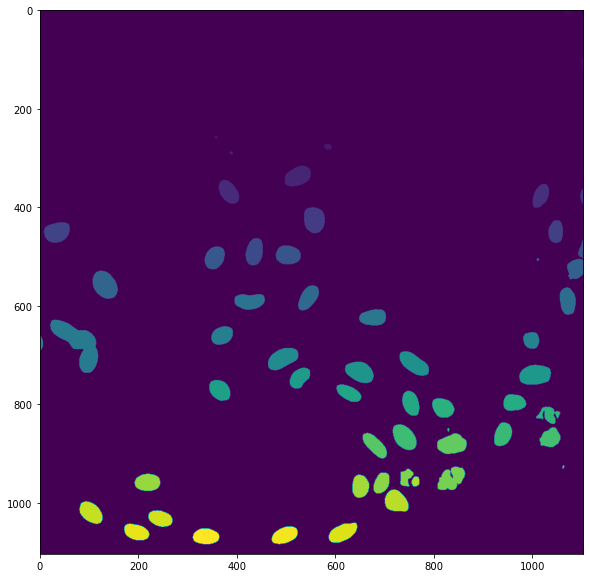

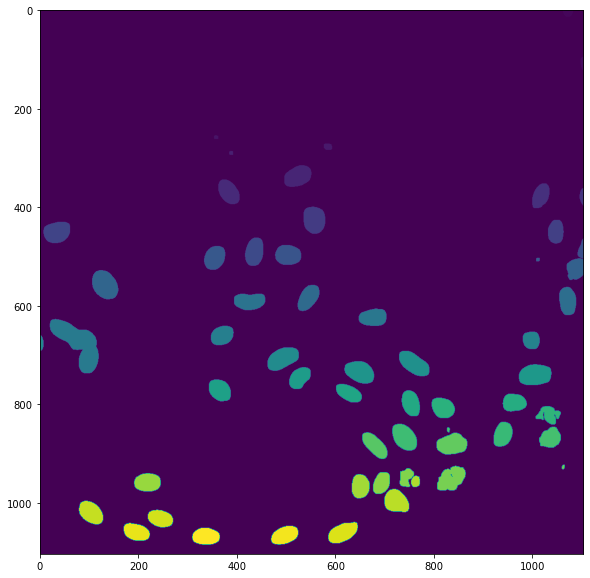

In [13]:
#all_images = data_partitions[partition]

config_vars["raw_annotations_dir"] = '../data/1_raw_annotations/'
config_vars["labels_out_dir"]      =\
'/proj/berzelius-2021-21/users/klara/Segmentation/data/experiments/Model_3_Malou/out_14/segm/'
all_images = data_partitions['test']

config_vars["object_dilation"] = 3

from skimage.color import rgb2gray,rgb2lab

results = pd.DataFrame(columns=["Image", "Threshold", "F1", "Jaccard", "TP", "FP", "FN"])

false_negatives = pd.DataFrame(columns=["False_Negative", "Area"])
false_positives = pd.DataFrame(columns=["False_Positive", "Area"])
gold_obj = pd.DataFrame(columns=["Gold_Object", "Area"])  # for counting the area of gold objects
pred_obj = pd.DataFrame(columns=["Pred_Object", "Area"])  # for counting area of predicted objects
      
        
        
splits_merges = pd.DataFrame(columns=["Image_Name", "Merges", "Splits"])



for image_name in all_images:
    print(image_name)
    # Load ground truth data
    img_filename = os.path.join(config_vars["raw_annotations_dir"], image_name)
    ground_truth = skimage.io.imread(img_filename)
    #ground_truth = ground_truth.squeeze()
    if len(ground_truth.shape) == 3:
        ground_truth = rgb2lab(ground_truth)
        ground_truth = ground_truth[:,:,0]
    
    ground_truth = skimage.morphology.label(ground_truth)
    
    # Transform to label matrix
    #ground_truth = skimage.morphology.label(ground_truth)
    
    # Load predictions
    pred_filename = os.path.join(config_vars["labels_out_dir"], image_name)
    prediction = skimage.io.imread(pred_filename)
    
    
    if len(prediction.shape) == 3:
        prediction = rgb2lab(prediction)
        prediction = prediction[:,:,0]
    plt.figure(figsize=(10,10))    
    plt.imshow(ground_truth)
    plt.figure(figsize=(10,10))
    plt.imshow(prediction)
    if config_vars["object_dilation"] > 0:
            struct = skimage.morphology.square(config_vars["object_dilation"])
            prediction = skimage.morphology.dilation(prediction, struct)
    elif config_vars["object_dilation"] < 0:
            struct = skimage.morphology.square(-config_vars["object_dilation"])
            prediction = skimage.morphology.erosion(prediction, struct)
    plt.figure(figsize=(10,10))        
    plt.imshow(prediction)
    ####################################################################################    
    #### Testing prediction with no small objects on annot and prediction #####
    ground_truth = skimage.morphology.remove_small_objects(ground_truth, min_size=10)##min is 25 
    prediction = skimage.morphology.remove_small_objects(prediction, min_size=10)
    #####################################################################################
    
    # Relabel objects (cut margin of 30 pixels to make a fair comparison with DeepCell)
    ground_truth = skimage.segmentation.relabel_sequential(ground_truth)[0] #[30:-30,30:-30])[0]
    prediction = skimage.segmentation.relabel_sequential(prediction)[0] #[30:-30,30:-30])[0]
  
    # Compute evaluation metrics
    results = compute_af1_results(
        ground_truth, 
        prediction, 
        results, 
        image_name
    )
    
    false_negatives = get_false_negatives(
        ground_truth, 
        prediction, 
        false_negatives, 
        image_name
    )
    
    false_positives = get_false_positives(
        ground_truth, 
        prediction, 
        false_positives, 
        image_name
    )
    
    splits_merges = get_splits_and_merges(
        ground_truth, 
        prediction, 
        splits_merges, 
        image_name
    )
    
    gold_obj = get_gold_objects(
          ground_truth, 
          prediction, 
          gold_obj, 
          image_name
      )
    pred_obj = get_predicted_objects(
          ground_truth, 
          prediction, 
          pred_obj, 
          image_name
      )
    
   
    

In [127]:
true_positive = false_negatives.copy()
true_positive

,Area,False_Negative
0,1781,0
1,1774,0
2,2395,0
3,1765,0
4,10,1
5,43,1
6,1621,0
7,1357,0
8,1152,0
9,1135,0


# Report of results

### The following cells are for categorizing the TP, FP, and FN objects size-wise

In [128]:
# Summarize False Negatives by area

false_negatives = false_negatives[false_negatives["False_Negative"] == 1]

false_negatives.groupby(
    pd.cut(
        false_negatives["Area"], 
        [0,100,1000,2100,30000], # Area intervals
        labels=["Tiny nuclei","Small nuclei","Normal nuclei","Large nuclei"],
    )
)["False_Negative"].sum()

Area
Tiny nuclei      46
Small nuclei     27
Normal nuclei    35
Large nuclei      8
Name: False_Negative, dtype: int64

In [129]:
falseP = false_positives[false_positives["False_Positive"] == 1]

FP_Area_chart = falseP.groupby(
    pd.cut(
        falseP["Area"], 
        [0,100,1000,2100,30000], # Area intervals
        labels=["Tiny nuclei","Small nuclei","Normal nuclei","Large nuclei"],
    )
)["False_Positive"].sum()

total_Positives = len(false_positives)
print(FP_Area_chart)

print("FDR Tiny:", "%.4f" % (FP_Area_chart["Tiny nuclei"]/total_Positives))

print("FDR Small:", "%.4f" % (FP_Area_chart["Small nuclei"]/total_Positives))

print("FDR Normal:", "%.4f" % (FP_Area_chart["Normal nuclei"]/total_Positives))

print("FDR Large:", "%.4f" % (FP_Area_chart["Large nuclei"]/total_Positives))


Area
Tiny nuclei      15
Small nuclei     11
Normal nuclei     1
Large nuclei      3
Name: False_Positive, dtype: int64
FDR Tiny: 0.0353
FDR Small: 0.0259
FDR Normal: 0.0024
FDR Large: 0.0071


In [130]:
# Summarize False Negatives by area

true_P = true_positive[true_positive["False_Negative"] == 0]

true_P['False_Negative'] = 1
TP_Area_chart = true_P.groupby(
    pd.cut(
        true_P["Area"], 
        [0,100,1000,2100,30000], # Area intervals
        labels=["Tiny nuclei","Small nuclei","Normal nuclei","Large nuclei"],
    )
)["False_Negative"].sum()
TP_Area_chart

/proj/berzelius-2021-21/users/Salma-files/envs/UNET_TF_1/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Area
Tiny nuclei        0
Small nuclei      14
Normal nuclei    240
Large nuclei      66
Name: False_Negative, dtype: int64

In [131]:
gold_obj['Gold_Obj'] = 1


GO_Area_chart = gold_obj.groupby(
    pd.cut(
        gold_obj["Area"], 
        [0,100,1000,2100,30000], # Area intervals
        labels=["Tiny nuclei","Small nuclei","Normal nuclei","Large nuclei"],
    )
)['Gold_Obj'].sum()


print(GO_Area_chart.sum())

GO_Area_chart


436


Area
Tiny nuclei       46
Small nuclei      41
Normal nuclei    275
Large nuclei      74
Name: Gold_Obj, dtype: int64

In [132]:
# Summarize splits and merges

print("Splits:",np.sum(splits_merges["Splits"]))
print("Merges:",np.sum(splits_merges["Merges"]))

Splits: 5
Merges: 5


In [98]:
# Report false positives

print("Extra objects (false postives):",results[results["Threshold"].round(3) == 0.9].sum()["FP"])

Extra objects (false postives): 24


In [133]:
thresh = 0.9


FP = results[results["Threshold"].round(3) == thresh].sum()["FP"]
FN = results[results["Threshold"].round(3) == thresh].sum()["FN"]
TP = results[results["Threshold"].round(3) == thresh].sum()["TP"]
Total = FP + TP

print("Extra objects (false postives):",FP)

print("True positives:",TP)

print("Total objects:",Total)

print("False discovery rate:", FP/Total)

Extra objects (false postives): 30
True positives: 320
Total objects: 350
False discovery rate: 0.08571428571428572


# **EPOCHS COMPARISON**

In [1]:
#all_images = data_partitions[partition]


config_vars["raw_annotations_dir"] = '../data/1_raw_annotations/'
config_vars["labels_out_dir"]      =\
'/proj/berzelius-2021-21/users/klara/Segmentation/data/experiments/Model_3_Malou/out_3/segm/'
all_images = data_partitions['validation']
config_vars["object_dilation"] =3

from skimage.color import rgb2gray,rgb2lab

epochs_results = pd.DataFrame(columns=["Average F1 Score", "Average Jaccard Index", "False Negatives", "False Positives", "True Positives", "Detected Objects", "False Discovery Rate"])
best_models = [3,12,14]
for m_n in best_models:
    config_vars["labels_out_dir"]      = '../data/experiments/Model_3_Malou/out_'+str(m_n)+'/segm/'

    print("################################################################")
    print("Model number", m_n)

    results = pd.DataFrame(columns=["Image", "Threshold", "F1", "Jaccard", "TP", "FP", "FN"])
    false_negatives = pd.DataFrame(columns=["False_Negative", "Area"])
    false_positives = pd.DataFrame(columns=["False_Positive", "Area"])
    gold_obj = pd.DataFrame(columns=["Gold_Object", "Area"])
    pred_obj = pd.DataFrame(columns=["Pred_Object", "Area"])
    splits_merges = pd.DataFrame(columns=["Image_Name", "Merges", "Splits"])

    for image_name in all_images:
      # Load ground truth data  
        img_filename = os.path.join(config_vars["raw_annotations_dir"], image_name)
        ground_truth = skimage.io.imread(img_filename)
        #ground_truth = ground_truth.squeeze()
        if len(ground_truth.shape) == 3:
            ground_truth = rgb2lab(ground_truth)
            ground_truth = ground_truth[:,:,0]

        ground_truth = skimage.morphology.label(ground_truth)

        # Transform to label matrix
        #ground_truth = skimage.morphology.label(ground_truth)

        # Load predictions
        pred_filename = os.path.join(config_vars["labels_out_dir"], image_name)
        prediction = skimage.io.imread(pred_filename)


        if len(prediction.shape) == 3:
            prediction = rgb2lab(prediction)
            prediction = prediction[:,:,0]


        gold_obj = get_gold_objects(
              ground_truth, 
              prediction, 
              gold_obj, 
              image_name
          )
        pred_obj = get_predicted_objects(
              ground_truth, 
              prediction, 
              pred_obj, 
              image_name
          )

          # Apply object dilation
        if config_vars["object_dilation"] > 0:
            struct = skimage.morphology.square(config_vars["object_dilation"])
            prediction = skimage.morphology.dilation(prediction, struct)
        elif config_vars["object_dilation"] < 0:
            struct = skimage.morphology.square(-config_vars["object_dilation"])
            prediction = skimage.morphology.erosion(prediction, struct)
      
        ####################################################################################    
        #### Testing prediction with no small objects on annot and prediction #####
        ground_truth = skimage.morphology.remove_small_objects(ground_truth, min_size=100) 
        prediction = skimage.morphology.remove_small_objects(prediction, min_size=100)
        #####################################################################################
        plt.imshow(prediction)
        # Relabel objects (cut margin of 30 pixels to make a fair comparison with DeepCell)
        ground_truth = skimage.segmentation.relabel_sequential(ground_truth)[0] #[30:-30,30:-30])[0]
        prediction = skimage.segmentation.relabel_sequential(prediction)[0] #[30:-30,30:-30])[0]


        # Compute evaluation metrics
        results = compute_af1_results(
          ground_truth, 
          prediction, 
          results, 
          image_name
        )

        false_negatives = get_false_negatives(
          ground_truth, 
          prediction, 
          false_negatives, 
          image_name
        )

        false_positives = get_false_positives(
          ground_truth, 
          prediction, 
          false_positives, 
          image_name
        )

        splits_merges = get_splits_and_merges(
          ground_truth, 
          prediction, 
          splits_merges, 
          image_name
        )




  # Display an example image
  #if image_name == all_images[0]:
      #show(ground_truth, prediction, image_name=image_name)


    # Display accuracy results

    average_performance = results.groupby("Threshold").mean().reset_index()


    R = results.groupby("Image").mean().reset_index()
    #g = sb.jointplot(data=R[R["F1"] > 0.4], x="Jaccard", y="F1")

    #average_performance
    R.sort_values(by="F1",ascending=False)

    # Plot accuracy results

    #sb.regplot(data=average_performance, x="Threshold", y="F1", order=3, ci=None)
    print(average_performance)


    # Compute and print Average F1

    F1_score_90 = average_performance["F1"][8] # I want only 90%

    #average_performance["F1"].mean()
    jaccard_index = average_performance["Jaccard"].mean()
    print("Average F1 score:", F1_score_90 )
    print("Jaccard index:", jaccard_index)


    # calculate true postives and false positives
    thresh = 0.9

    FP = results[results["Threshold"].round(3) == thresh].sum()["FP"]
    TP = results[results["Threshold"].round(3) == thresh].sum()["TP"]
    FN = results[results["Threshold"].round(3) == thresh].sum()["FN"]
    Total = FP + TP

    print("False negatives:",FN)
    print("False postives:",FP)
    print("True positives:",TP)

    print("Total objects:",Total)

    print("False discovery rate:", FP/Total)

    epochs_results.loc[m_n] = [F1_score_90 , jaccard_index, FN, FP, TP, Total, FP/Total]

    print('#############################################')

NameError: name 'config_vars' is not defined

In [111]:
epochs_results.rename(columns={'Average F1 Score':'F1_score_90'},inplace=True)
epochs_results['Precision']=epochs_results['True Positives']/(epochs_results['False Positives']+epochs_results['True Positives'])
epochs_results['Recall']=epochs_results['True Positives']/(epochs_results['False Negatives']+epochs_results['True Positives'])

epochs_results

,F1_score_90,Average Jaccard Index,False Negatives,False Positives,True Positives,Detected Objects,False Discovery Rate,Precision,Recall
3,0.809952,0.871175,89.0,17.0,240.0,257.0,0.066148,0.933852,0.729483
12,0.806144,0.880613,98.0,9.0,231.0,240.0,0.037500,0.962500,0.702128
14,0.846058,0.878350,77.0,17.0,252.0,269.0,0.063197,0.936803,0.765957
